# COVID Dashboard

Analysis of current COVID 19 new case data from multiple sources

## Load Data and Normalize
COVID data is loaded from __Johns Hopkins CSSE__ Github site into a __Pandas__ DataFrame. US county population data is also loaded into a DataFrame and merged with COVID data. Seven day rolling average per 100k population is calculated for full dataset.

In [73]:
#Load online county csv data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import time
from datetime import datetime, timedelta
import matplotlib.colors as colors
import matplotlib.cm as cm
#mapping
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
#imaging
import glob
from PIL import Image
import importlib
import dashboard_utils as utils
import logging as log
import us_state_codes as stcd

importlib.reload(utils)
importlib.reload(stcd)

csse_us_county_cases_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv';

county_pop_url = 'https://raw.githubusercontent.com/balsama/us_counties_data/main/data/counties.csv'

print("Loading CSSE County CSV data...")

csse_plot_days = 60
csse_max_days = 600

current_date = ''
try:
    csse_county_df = pd.read_csv(csse_us_county_cases_URL, parse_dates=True)
except:
    print("ERROR: Can't load CSSE data")
    log.error("ERROR: Can't load CSSE data")
    
print(csse_county_df.shape)
log.debug(csse_county_df.dtypes)
log.debug(csse_county_df.head)

log.info("this is log.info")
print("Loading US population data...")
try:
    county_pop_df = pd.read_csv(county_pop_url, parse_dates=True) #, usecols=['FIPS Code', 'Population'])
except:
    print("ERROR: Can't load Population data")
print(county_pop_df.shape)
log.debug(county_pop_df.dtypes)
log.debug(county_pop_df.head)

log.debug(dir(utils))

# declare global variables
# get latest csse county values
csse_current_county_values = dict()
csse_counties_norm_cases_df = pd.DataFrame()
csse_full_counties_norm_cases_df = pd.DataFrame()
fullData_gdf = gpd.GeoDataFrame()
csse_series_list = list() # global list of extracted county time series

#normalize all counties with population and calculate 7 day moving ave / 100k
csse_full_counties_norm_cases_df = utils.merge_and_calculate_full_new_cases(csse_county_df, county_pop_df)

Loading CSSE County CSV data...
(3342, 779)
Loading US population data...
(3094, 6)
Merging Case and Population data...
(3103, 784)
Calculating normalized ave new cases...
(3103, 769)
merge_and_calculate_full_new_cases() completed: 7.548649549484253


## Plot Data for Selected Counties


Box(children=(HTML(value='<center><b>Plot Control</b></center>', layout=Layout(width='auto')), HBox(children=(…

calling extract_plot_counties()
in extract_plot_counties
test_df (3, 769)  num_days_index:  -60
Douglas, NE
Lancaster, NE
Sarpy, NE
out_df: (60, 3)
csse_counties_norm_cases_df:  (60, 3)
in plot_current_csse_case_values()
in set_graph_background_color_bands() max_value = 8.993965049451818
In csse_extract_and_plot_time_series()
in set_graph_background_color_bands() max_value = 301.25016827144486


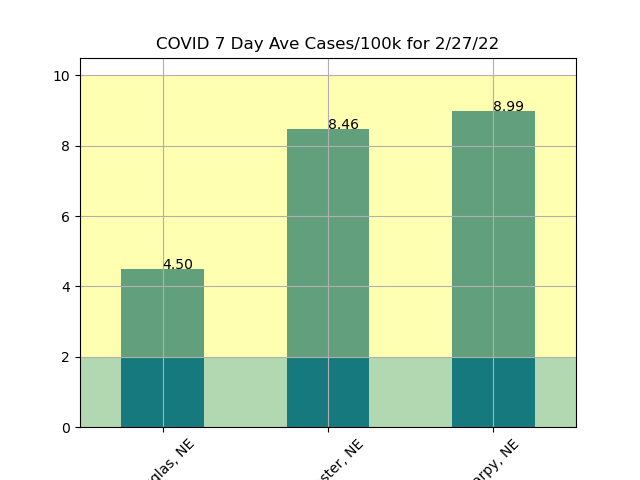

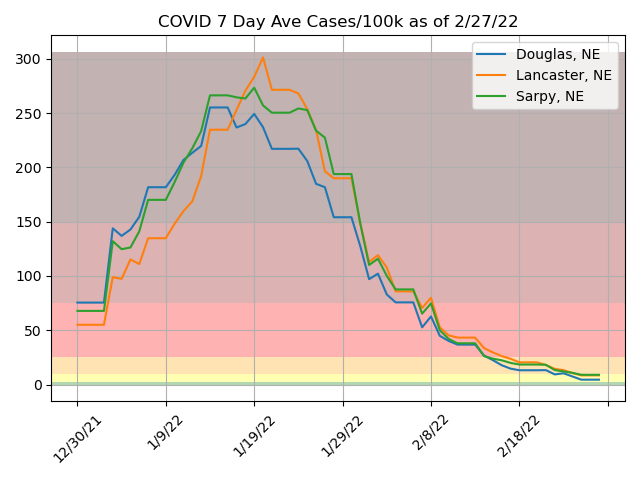

In [63]:

# create axes for plots and enable interactive mode if not on Google Colab
#%matplotlib widget
%matplotlib widget
csse_current_values_graph, csse_current_values_axes = plt.subplots()
csse_ave_cases_graph, csse_ave_cases_axes = plt.subplots()

# define colormap for plotting and map
color_list = ['green', 'yellow','orange', 'red', 'darkred', '#380000']
mapping_cmap = colors.ListedColormap(color_list)
boundaries = [0, 2, 10, 25, 75, 150, 1000]
map_color_norm = colors.BoundaryNorm(boundaries, mapping_cmap.N, clip=True)


# get all county values for searches
csse_county_list = csse_county_df['Combined_Key'].unique()

#output widget for all graph generation
graphs_out = widgets.Output(layout={'border': '1px solid black', 'height':'200px',
    'overflow_y' : 'scroll'})

# populate multiple select widget with counties
#output_csse_county = widgets.Output()
csse_county_select = widgets.SelectMultiple(
    options=csse_county_list.tolist(),
    name='US Counties',
    value=['Douglas, Nebraska, US', 'Sarpy, Nebraska, US', 'Lancaster, Nebraska, US'],
    rows=15,
    description='US Counties',
    disabled=False,
    layout={'width': 'auto'}
)

plt_range = widgets.IntSlider(description = 'Days to Plot', 
                            value = csse_plot_days, 
                            orientation='vertical',
                            min = 30, 
                            max = csse_max_days,
                            layout={'width': 'auto'});

def on_value_change(change):
    global csse_plot_days
    
    with graphs_out:
        #print(change['new'])
        csse_plot_days = plt_range.value
        
plt_range.observe(on_value_change, names='value')


# add plot button
#output_csse_button = widgets.Output()
csse_plot_button = widgets.Button(description='Plot', layout={'width': 'auto', 'align' : 'center'})
#display(csse_plot_button, output_csse_button)
def csse_on_button_clicked(b):
    global csse_counties_norm_cases_df
    with graphs_out:
        #global ave_cases_graph
        #global ave_cases_axes
        #ave_cases_graph.clear()
        #plt.clf()
        
        clear_output(wait = True)
        
        print("Replotting with Selected Counties")
        print(csse_county_select.value)
        csse_counties_norm_cases_df = utils.extract_plot_counties(csse_full_counties_norm_cases_df, csse_county_select.value, plt_range.value)
        #get_latest_csse_county_values(csse_county_select.value)

        print("calling - plot_current_csse_case_values")
        csse_current_values_axes.cla()
        #csse_current_values_graph.clf()
        csse_plot_current_case_values()
        csse_current_values_axes.redraw_in_frame()

        csse_extract_and_plot_time_series()
        
        #[l.remove() for l in ax.lines]
        #ave_cases_axes = extract_and_plot_time_series()
        #ave_cases_axes.redraw_in_frame()
        #print("Button clicked: " +str(plot_days))

csse_plot_button.on_click(csse_on_button_clicked)

graph_box_title = widgets.HTML('<center><b>Plot Control</b></center>', layout={'width': 'auto', 'align' : 'center'})


vbox_layout = widgets.Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch', #center
                    border='solid',
                    width='80%')

hbox = widgets.HBox([csse_county_select, plt_range])
graph_vbox = widgets.Box([graph_box_title, hbox, csse_plot_button, graphs_out],
                   layout=vbox_layout)


#vbox = widgets.VBox([hbox,csse_plot_button, graphs_out])

#display(csse_county_select, output_csse_county)
#display(graphs_out)
display(graph_vbox)

    
# plot bar graph of current case numbers
#@graphs_out.capture()
def csse_plot_current_case_values():
    print("in plot_current_csse_case_values()")
    #global csse_current_county_values
    global csse_current_new_cases
    global csse_current_values_axes
    global csse_counties_norm_cases_df
    
    #print(csse_counties_norm_cases_df.head) 
    
    
    csse_current_values_axes.cla()
    #csse_current_values_graph.clf()
    
    csse_current_county_values = csse_counties_norm_cases_df.iloc[-1, :]
 
    current_date = csse_county_df.columns[-1]

    #find max of current values to size graph appropriately
    cases_set_max = max(csse_current_county_values) #douglas_current, sarpy_current, lancaster_current)
    #print("max; " +str(cases_set_max))

    #current_values_axes = current_new_cases.plot(kind="bar", ax=current_values_axes)
    csse_current_values_axes = csse_current_county_values.plot(kind="bar", 
                ax=csse_current_values_axes,
                rot=45)
  
    # show values on bar graph, format to display 2 decimal places
    for index, value in enumerate(csse_current_county_values):
        csse_current_values_axes.text(index, value,
             '{:.2f}'.format(value))
        #print(value)
        
    csse_current_values_axes.set_title("COVID 7 Day Ave Cases/100k for " +str(current_date))
    
    csse_current_values_axes.grid()

    # add color bands for severity 
    utils.set_graph_background_color_bands(csse_current_values_axes, cases_set_max, color_list)
    
    #csse_current_cases_graph.tight_layout()
    csse_current_cases_graph.subplots_adjust(bottom=0.05)
    
    plt.xticks(rotation=45, ha='right')
    #csse_current_values_axes.set_xticklabels(csse_current_values_axes.get_xticks(), rotation = 45)
  
    #csse_current_cases_graph.show()
    
# extract and plot daily ave new cases / 100k

def csse_extract_and_plot_time_series():
    print('In csse_extract_and_plot_time_series()')
    global csse_ave_cases_graph
    global csse_ave_cases_axes
    global csse_counties_norm_cases_df
    
    csse_ave_cases_axes.cla()
    #csse_ave_cases_graph.clf()
    
    #print("csse_counties_norm_cases_df type:" +str(type(csse_counties_norm_cases_df)))
    #print(csse_counties_norm_cases_df)
    
    current_date = csse_county_df.columns[-1]
          
    max_value = csse_counties_norm_cases_df.max().max()
    #print("Max value: ")
    #print(max_value)
    
    
    csse_ave_cases_axes = csse_counties_norm_cases_df.plot(ax=csse_ave_cases_axes, rot=45)
    
    csse_ave_cases_axes.set_title("COVID 7 Day Ave Cases/100k as of " +str(current_date))
    
    utils.set_graph_background_color_bands(csse_ave_cases_axes, max_value, color_list)
    
    csse_ave_cases_axes.grid()
    
    #csse_ave_cases_axes.set_xticklabels(csse_ave_cases_axes.get_xticks(), rotation = 45)
    #plt.xticks(rotation=45, ha='right')
    csse_ave_cases_graph.tight_layout()
    #csse_ave_cases_graph.show()
    #print("ave_cases_graph: ")
    #print(type(ave_cases_graph))

    #counties_norm_cases.style
    
#merge_and_calculate_full_new_cases()

#get_latest_csse_county_values(csse_county_select.value)
#extract_plot_counties(csse_county_select.value)
print('calling extract_plot_counties()')
csse_counties_norm_cases_df = utils.extract_plot_counties(csse_full_counties_norm_cases_df, csse_county_select.value, plt_range.value)
print('csse_counties_norm_cases_df: ', csse_counties_norm_cases_df.shape)

csse_plot_current_case_values()

csse_extract_and_plot_time_series()





## Plot Chloropleth Map of Current Cases
Load US CONUS county map data in _geojson_ format into __GeoPandas__ GeoDataFrame. Merge with normalized CSSE DataFrame and plot. County color is set using same map as graph backgrounds.

Output(layout=Layout(border='1px solid black', height='200px', overflow_y='scroll'))

in build_chloro_map()
map date:  2/27/22
shape: (3103, 769) columns:  <class 'pandas.core.indexes.base.Index'>
fullData_gdf:  Index(['id', 'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA',
       'geometry', 'Combined_Key', '1/22/20',
       ...
       '2/18/22', '2/19/22', '2/20/22', '2/21/22', '2/22/22', '2/23/22',
       '2/24/22', '2/25/22', '2/26/22', '2/27/22'],
      dtype='object', length=777)


C:\Users\phild\anaconda3\envs\geo_env\lib\site-packages\geoplot\geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


Saving to 2-27-22.jpg


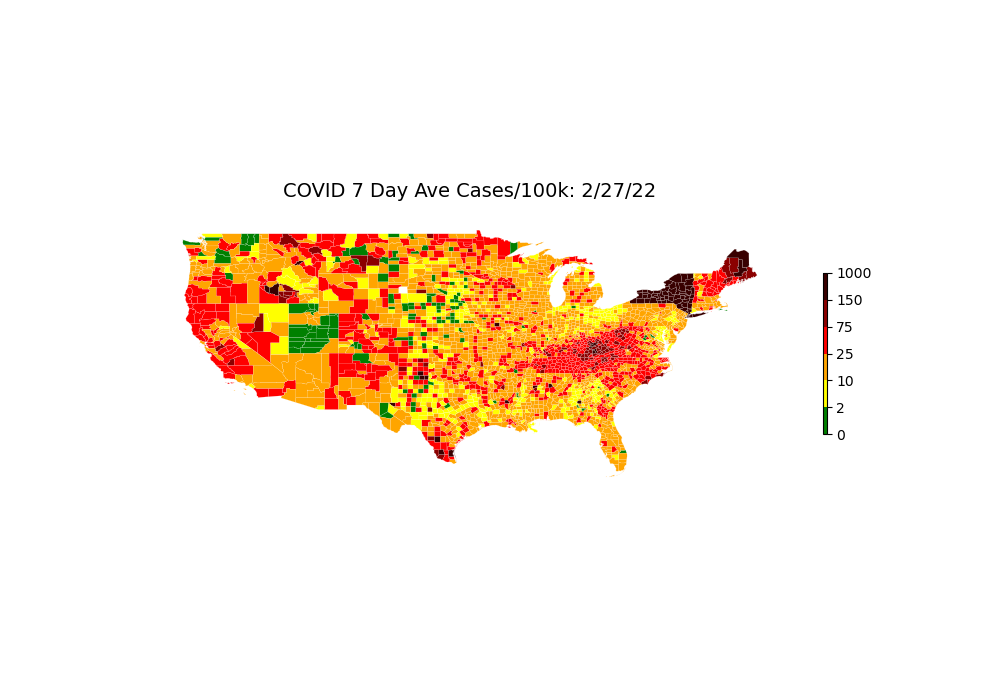

In [67]:
map_fig, map_ax = plt.subplots(1, 1, figsize=(10, 7))
map_out = widgets.Output(layout={'border': '1px solid black', 'height':'200px',
    'overflow_y' : 'scroll'})

display(map_out)
  

def build_chloro_map():
    print('in build_chloro_map()')
    global csse_full_counties_norm_cases_df
    global mapping_cmap
    global map_color_norm
    global current_date
    global fullData_gdf
    global map_fig
    global map_ax
    
    #print(gplt.datasets)
    # Load the json file with county coordinates
    try:
        geoData_gdf = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
    except:
        print("ERROR: Can't load map data")

    # Make sure the "id" column is an integer
    geoData_gdf.id = geoData_gdf.id.astype(str).astype(int)

    # Remove Alaska, Hawaii and Puerto Rico.
    stateToRemove = ['02', '15', '72']
    geoData_gdf = geoData_gdf[~geoData_gdf.STATE.isin(stateToRemove)]
    
    #print(geoData_gdf.head)

    # Basic plot with just county outlines to test map data
    #gplt.polyplot(geoData_gdf, figsize=(10, 5), linewidth=.2)
    
    # build extracted df for given date containing id column
    current_date = csse_full_counties_norm_cases_df.columns[-1]
    #date = current_date
    print('map date: ', current_date)
    print('shape:', csse_full_counties_norm_cases_df.shape, 'columns: ', type(csse_full_counties_norm_cases_df.columns))

    # merge extracted df with geodata
    #fullData = geoData.merge(csse_full_counties_norm_cases_df, left_on=['id'], right_on=['FIPS'])
    fullData_gdf = geoData_gdf.merge(csse_full_counties_norm_cases_df, left_on=['id'], right_index=True)
    print('fullData_gdf: ', fullData_gdf.columns)
    #print(fullData_gdf)
    
    #douglas_value = fullData_gdf.loc[geoData_gdf['id'] == 31055]
    #print('Douglas, NE geo row: ')
    #print_full( douglas_value)
    
    #print(map_color_norm.__run__(0.0, clip=True))
    
    # get list of all dates from columns
    column_list = csse_full_counties_norm_cases_df.columns.to_list()
          
    # start about 10 days in to avoid NaN values from rolling average + name column
    all_dates = column_list[11:]
    #print('dates: ', all_dates)
    
    # plot chloropleth
    
    #try to make map bigger by shrinking margins
    map_ax.margins(x=0.01)
    
    map_fig.colorbar(cm.ScalarMappable(norm=map_color_norm, cmap=mapping_cmap), 
        ax=map_ax, location='right', 
        aspect=40, 
        shrink=.3, 
        fraction=.1,
        pad=.01,
        anchor=(0,0.5)
    )
    
    #select dates to map
    dates = all_dates[-1:]
    
    for date in dates:
        plot_map(date, fullData_gdf, map_fig, map_ax)
    
    #build_animated_gif(dates)


def plot_map(date, combined_df, fig, ax):
    #fig.clear()
    ax.clear()
    scheme = mc.UserDefined(combined_df[date], boundaries)
    
    gplt.choropleth(combined_df, 
        hue=date, 
        linewidth=.1,
        scheme=scheme, 
        #projection=gcrs.AlbersEqualArea(),
        cmap=mapping_cmap,
        #norm=map_color_norm,
        legend=False,
        edgecolor='white',
        ax=ax
    )
    
    ax.set_title('COVID 7 Day Ave Cases/100k: ' +str(date), fontsize=14)
    
    #fig.show()
    
    path = '../data/map-images/'
    fname = date.replace('/', '-') +'.jpg' 
    
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
    
    print('Saving to ' +fname)
    
    fig.savefig(path +fname)
    
#build animated gif of map images from sorted list of dates
def build_animated_gif(date_list, duration):
    print('building animated gif...')
    frame_dir = '../data/map-images/'
    output_dir = '../data/'
    output_fname = output_dir +'animated-covid-map.gif'
    
    frames = []
    
    for date in date_list:
        image_fname = frame_dir +date.replace('/', '-') +'.jpg'
        frames.append(Image.open(image_fname))
        
    #frames = [Image.open(image) for image in glob.glob(f"{frame_dir}/*.JPG")]
    frame_one = frames[0]
    frame_one.save(output_fname, format="GIF", append_images=frames,
               save_all=True, duration=duration, loop=0)
    print("generated file" +output_fname)


#calculate_full_rolling_averages_with_fips_index()

build_chloro_map()



## Animated GIF Builder
Date range is selectable over the entire dataset. Chloropleth map images are generated for each day in selected period. Animated GIF is built from the images.

In [ ]:
date_fmt_str = '%m/%d/%y'

gif_builder_out = widgets.Output(layout={'border': '1px solid black', 'height':'200px',
    'overflow_y' : 'scroll'})

end_datetime = datetime.strptime(current_date, date_fmt_str)
start_datetime = datetime(2020, 2, 1)
print('current_date: ', end_datetime)

gif_begin_datetime = end_datetime - timedelta(days = 10)

#gif_begin_date = start_date
gif_end_datetime = end_datetime

dates = pd.date_range(start_datetime, end_datetime, freq='D')

options = [(date.strftime(date_fmt_str), date) for date in dates]
index = (0, len(options)-1)

date_range_slider = widgets.SelectionRangeSlider(
    options=options,
    value=[gif_begin_datetime, gif_end_datetime],
    index=index,
    description='Date Range',
    orientation='horizontal',
    layout={'width': 'auto'}
)

#selection_range_slider

delay_slider = widgets.IntSlider(
    value=800,
    min=0,
    max=3000,
    step=50,
    description='Delay (ms)',
    orientation='horizontal',
    layout={'width': 'auto'}
)

def print_date_range(date_range):
    with gif_builder_out:
        print(date_range)

#widgets.interact(
#    print_date_range,
#    date_range=date_range_slider
#);

title = widgets.HTML('<center><b>Build Animated GIF</b></center>', layout={'width': 'auto', 'align' : 'center'})

def button_selected(b):
    global map_fig
    global map_ax
    
    with gif_builder_out:
        print('button pressed')
        print('delay:',delay_slider.value)
        print('date range:',date_range_slider.value)
        start_day = date_range_slider.value[0].strftime(date_fmt_str).replace("/0", "/").lstrip('0')
        end_day = date_range_slider.value[1].strftime(date_fmt_str).replace("/0", "/").lstrip('0')
        print('start day:', start_day, ' end day:', end_day)
        end_column = csse_full_counties_norm_cases_df.columns.get_loc(end_day)
        num_days = (date_range_slider.value[1] - date_range_slider.value[0]).days
        #date_columns = csse_full_counties_norm_cases_df.loc[start_day : end_day].columns
        print(end_column, num_days)
        date_columns = csse_full_counties_norm_cases_df.columns.to_list()[end_column-num_days : end_column+1]
        print(date_columns)
        
        for date in date_columns:
            plot_map(date, fullData_gdf, map_fig, map_ax)
            
        build_animated_gif(date_columns, delay_slider.value)
            

build_gif_button = widgets.Button(description='Build GIF', layout={'width': '80%', 'align' : 'center'})
build_gif_button.on_click(button_selected)

vbox_layout = widgets.Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch', #center
                    border='solid',
                    width='80%')

vbox = widgets.Box([title, date_range_slider, delay_slider, build_gif_button, gif_builder_out],
                   layout=vbox_layout)

display(vbox)

In [ ]:
%lsmagic

## Development Notes
### Stuff to work on
* _Fix interactive mode in Jupyterlab. 
    *[This might work](https://towardsdatascience.com/how-to-produce-interactive-matplotlib-plots-in-jupyter-environment-1e4329d71651)_
* Convert print staments to log output
* Fix missing data label
* _Handle exceptions in data loading_
* _County name formatting_
* Angular app widgets [ref](https://gist.github.com/disarticulate/d06069ff3e71cf828e5329beab8cb084)
* gpx notebook with interactive map
* MongoDB map animation
* Deploy to GoDaddy
* Deploy to AWS/EC2


In [50]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')